In [17]:
%load_ext autoreload
%aimport os, pandas, numpy, pickle
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import sys
import os
import pickle
import argparse
import pandas as pd
from sklearn.ensemble.forest import ExtraTreesRegressor

from fqi.et_tuning import run_tuning
from fqi.reward_function import *
from fqi.sars_creator import to_SARS
from fqi.utils import *

from trlib.policies.valuebased import EpsilonGreedy
from trlib.policies.qfunction import ZeroQ
from trlib.algorithms.reinforcement.fqi_driver import FQIDriver, DoubleFQIDriver
from trlib.environments.trackEnv import TrackEnv
from trlib.utilities.ActionDispatcher import *

from fqi.fqi_evaluate import run_evaluation

In [65]:
simulations = pd.read_csv('./trajectory/dataset.csv',
                              dtype={'isReference': bool, 'is_partial':bool})

ref_tr = pd.read_csv('./trajectory/ref_traj.csv')
ref_tr.columns = ['time', 'Acceleration_x', 'Acceleration_y', 'speed_x', 'speed_y',
       'xCarWorld', 'yCarWorld', 'alpha_step']

In [49]:
simulations

,NLap,time,isReference,is_partial,xCarWorld,yCarWorld,nYawBody,nEngine,NGear,prevaSteerWheel,...,speedDifferenceOfModules,actualAccelerationX,actualAccelerationY,referenceAccelerationX,referenceAccelerationY,accelerationDiffX,accelerationDiffY,aSteerWheel,pBrakeF,rThrottlePedal
0,1,0.307996,False,False,654.799744,1169.202148,0.013237,18466.84082,7,-0.001959,...,-2.462826,1.172228,-0.845928,1.300892,0.003601,0.128664,0.849529,-0.001715,0.0,1.0
1,1,0.407996,False,False,663.557922,1169.316528,0.012194,18489.47144,7,-0.001715,...,-2.416658,1.150649,-0.874358,1.277093,0.001861,0.126444,0.876219,-0.001714,0.0,1.0
2,1,0.507996,False,False,672.327209,1169.422852,0.011190,18511.70898,7,-0.001714,...,-2.371231,1.130063,-0.905710,1.252617,-0.000061,0.122554,0.905649,-0.001469,0.0,1.0
3,1,0.607996,False,False,681.107422,1169.519897,0.010168,18533.46802,7,-0.001469,...,-2.326653,1.105262,-0.868164,1.226950,-0.000073,0.121688,0.868091,-0.001469,0.0,1.0
4,1,0.707996,False,False,689.898254,1169.608398,0.009167,18554.90967,7,-0.001469,...,-2.282955,1.080983,-0.905741,1.200744,-0.000058,0.119761,0.905683,-0.001955,0.0,1.0
5,1,0.807996,False,False,698.699524,1169.687988,0.008132,18575.24536,7,-0.001955,...,-2.229615,1.002264,-0.913655,1.175719,0.000528,0.173455,0.914183,-0.001467,0.0,1.0
6,1,0.907996,False,False,707.510803,1169.758301,0.006860,18595.27344,7,-0.001467,...,-2.187247,1.047858,-1.253670,1.159796,0.000023,0.111938,1.253693,-0.002725,0.0,1.0
7,1,1.007996,False,False,716.331848,1169.815918,0.004919,18614.62280,7,-0.002725,...,-2.131727,1.009651,-1.718997,1.122303,0.000020,0.112652,1.719017,-0.003268,0.0,1.0
8,1,1.107996,False,False,725.162415,1169.856689,0.002823,18634.58374,7,-0.003268,...,-2.053136,0.976601,-1.813381,1.112550,0.000780,0.135949,1.814161,-0.003267,0.0,1.0
9,1,1.207996,False,False,734.002502,1169.879517,0.000749,18653.26904,7,-0.003267,...,-2.012541,1.055580,-1.839402,1.078666,0.000126,0.023086,1.839528,-0.003265,0.0,1.0


In [66]:
all_laps = np.unique(simulations.NLap)
lap_times = map(lambda lap: simulations[simulations.NLap == lap]['time'].values[-1], all_laps)
ref_time = ref_tr['time'].values[-1]
perc_deltas = list(map(lambda t: (abs(t - ref_time) / ref_time * 100) <= 1.5, lap_times))
right_laps = all_laps[perc_deltas]
right_laps

array([ 9., 14., 16., 17., 20., 47., 49., 55., 59., 60., 61., 62., 63.,
       65., 68.])

In [12]:
penalty = LikelihoodPenalty(bandwidth = 0.89, kernel = 'exponential')
penalty.fit(simulations[simulations.NLap.isin(right_laps)][state_cols].values, 10)

In [68]:
file_name = 'penalty.pkl'
with open('./' + file_name, 'rb') as pel:
     penalty = pickle.load(pel)

In [69]:
rf = Temporal_projection(ref_tr, penalty=penalty, clip_range=(-np.inf, np.inf))

In [43]:
lap = 12
dataset = to_SARS(simulations[simulations.NLap == lap], rf)

<IPython.core.display.Javascript object>


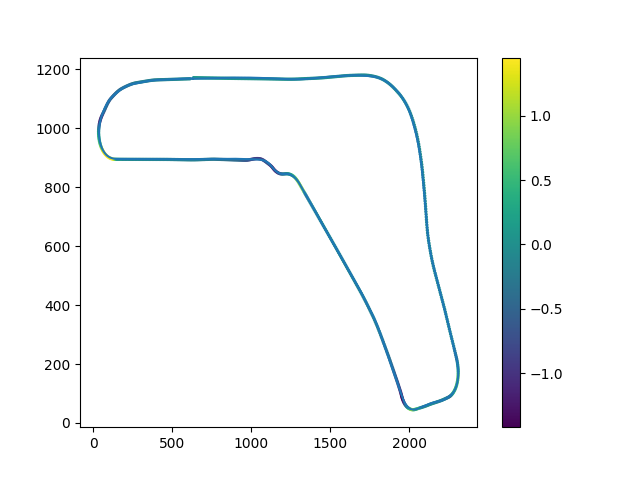

In [70]:
#[ 9., 14., 16., 17., 20., 47., 49., 55., 59., 60., 61., 62., 63., 65., 68.]
lap = 68
dataset = to_SARS(simulations[simulations.NLap == lap], rf)
%matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
ax.plot(ref_tr.xCarWorld, ref_tr.yCarWorld)

s = ax.scatter(dataset.xCarWorld, dataset.yCarWorld, c=dataset.r, s=2)
plt.colorbar(s, ax=ax)

In [72]:
trf_wp = Temporal_projection(ref_tr, penalty=penalty, clip_range=(-np.inf, np.inf))
trf = Temporal_projection(ref_tr)
lap = 12
dataset_with_p = to_SARS(simulations[simulations.NLap == lap], trf_wp)
dataset = to_SARS(simulations[simulations.NLap == lap], trf)

<IPython.core.display.Javascript object>


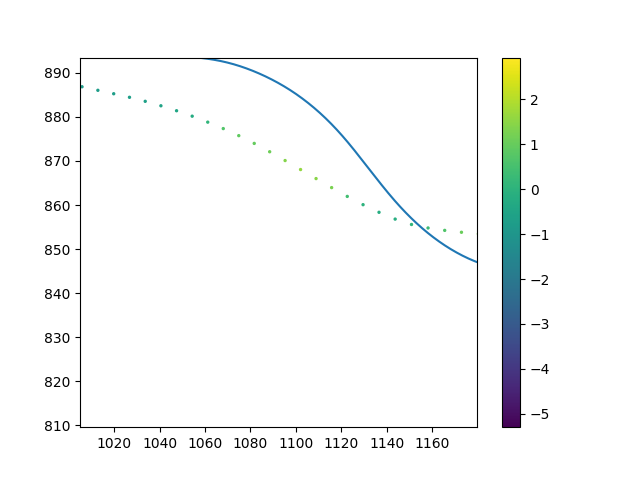

In [73]:
fig, ax = plt.subplots(1,1)
ax.plot(ref_tr.xCarWorld, ref_tr.yCarWorld)

s = ax.scatter(dataset.xCarWorld, dataset.yCarWorld, c=dataset.r, s=2)
plt.colorbar(s, ax=ax)

<IPython.core.display.Javascript object>


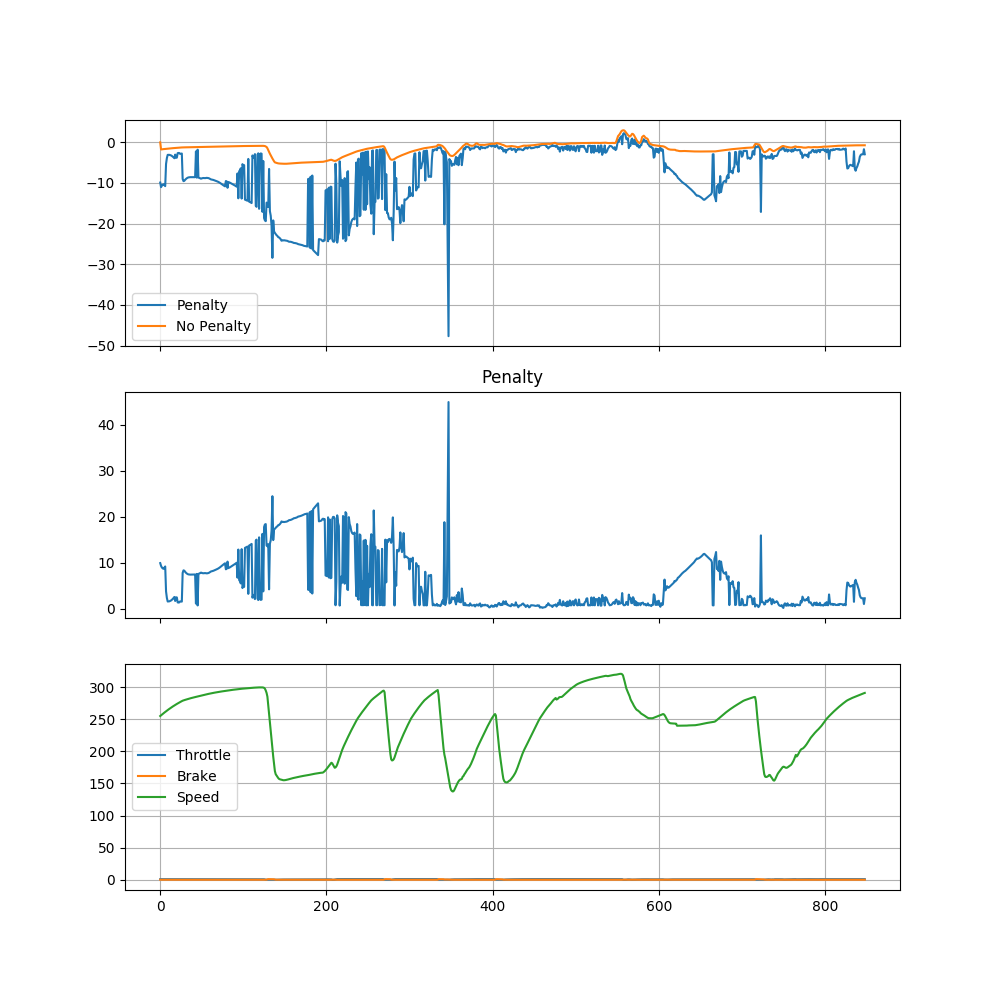

In [74]:
f, axs = plt.subplots(3, 1, sharex=True, figsize=[10,10])
axs[0].plot(dataset_with_p.r.values)
axs[0].plot(dataset.r.values)
axs[0].legend(['Penalty', 'No Penalty'])
axs[0].grid()

axs[1].plot(dataset.r.values - dataset_with_p.r.values)
axs[1].set_title('Penalty')

axs[2].plot(dataset.rThrottlePedal.values)
axs[2].plot(dataset.pBrakeF.values)
axs[2].plot(dataset.actualSpeedModule.values)
axs[2].legend(['Throttle', 'Brake', 'Speed'])
axs[2].grid()